# 새로운 도전, Sun Angle, 만들기, GHI 만들기

유튜브로 태양광 발전에 대한 공부를 좀 하고 왔습니다. 역시 도메인 공부를 해야 합니다. 깨우친 것은 다음과 같습니다.

1. 태양광은 여름보다 봄이 효율이 더 좋다. -> 기온에 매우 민감하다.
    1.1 기온이 25도씨가 넘어가면 효율이 떨어지기 시작한다.
    1.2 일조량도 중요하지만 기온도 매우 중요하다.
    
2. 남중고도각이라는 게 있다. 서울은 12시 30분에 정남향이다.
    1.1 하지 75.9도, 동지 28.9도로 매 절기마다 3.9도씩 변한다.
    
즉, 매번 90도로 남중고도각을 맞췄던 기존의 GHI는 너무 오차가 큰 것이었습니다. 동지는 30도도 되지 않습니다.

그렇다면 이것을 어떻게 활용하느냐?! 저렇게 오차가 크다면 계절을 알아야 하지 않겠느냐? 근데 테스트 데이터는 모르지 않느냐?!

-> 이것은 정지훈 선생께서 말씀하신, 해당 테스트 데이터를 트레인 데이터의 구간에 맞춰서 유사도를 측정하여 날짜를 추정하는 알고리즘을 만들어야 겠습니다.

해당 기간의 날짜만 나온다면, 자동으로 Sun angle을 뽑을 수 있고, 자동으로 조금 더 정확한 GHI를 뽑을 수 있습니다.

아키텍쳐를 짜봅시다.

일단 시계열성을 가지고 있는 column을 시각화를 통해 알아왔습니다.
- Target, T, RH 이렇게 3가지를 활용할 것입니다.

1. 각 column을 특정 구간의 동일 column과 비교해서 유사도를 측정합니다.
2. 그 유사도 값들을 다시 평균 냅니다.
3. 그 값이 가장 최소가 되는 되는 구간을 내뱉습니다.

In [272]:
import load_dtypes as ld
import warnings
warnings.filterwarnings(action='ignore')
import os, sys

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import numpy as np
from scipy.spatial import distance

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold

In [273]:
TRAIN_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv'
TEST_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\test'
SUBMISSION_PATH = r'C:\Users\Wyatt\wyatt37\Data\solarpanel\sample_submission.csv'

In [274]:
train = ld.load_dtypes(TRAIN_PATH)
train.info()
submission = pd.read_csv(SUBMISSION_PATH)
test = ld.load_dtypes(TEST_PATH + '/0.csv')

C:\Users\Wyatt\wyatt37\Data\solarpanel\train\train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int16  
 1   Hour    52560 non-null  int8   
 2   Minute  52560 non-null  int8   
 3   DHI     52560 non-null  int16  
 4   DNI     52560 non-null  int16  
 5   WS      52560 non-null  float32
 6   RH      52560 non-null  float32
 7   T       52560 non-null  int8   
 8   TARGET  52560 non-null  float32
dtypes: float32(3), int16(3), int8(3)
memory usage: 1.1 MB
C:\Users\Wyatt\wyatt37\Data\solarpanel\test/0.csv


In [275]:
# hour와 minute을 합쳐주는 함수입니다.
def sum_hour_minute(train):
    # 0과 30으로 되어 있는 minute을 0과 0.5로 바꿉니다.
    train.Minute = round(train.Minute * 0.017, 1)
    # hour에 minute을 더해줍니다.
    train.Hour = train.Hour + train.Minute
    
    return train

In [276]:
train = sum_hour_minute(train)
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0.0,0.0,0,0,1.5,69.080002,-12,0.0
1,0,0.5,0.5,0,0,1.5,69.059998,-12,0.0
2,0,1.0,0.0,0,0,1.6,71.779999,-12,0.0
3,0,1.5,0.5,0,0,1.6,71.750000,-12,0.0
4,0,2.0,0.0,0,0,1.6,75.199997,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21.5,0.5,0,0,2.4,70.699997,-4,0.0
52556,1094,22.0,0.0,0,0,2.4,66.790001,-4,0.0
52557,1094,22.5,0.5,0,0,2.2,66.779999,-4,0.0
52558,1094,23.0,0.0,0,0,2.1,67.720001,-4,0.0


## Step-1: Add Season to Train

train 데이터에 계절값을 넣어주겠습니다.<br>
그러려면 해당 day가 어느 시즌인지를 추정할 수 있어야 합니다.<br>
시즈널러티와 트렌드를 통해 얼추 추정은 하겠으나, 정확히 추정해야 하기 때문에 기준 값을 찾아야 합니다.

어렵네요. 최근 3년간의 데이터를 살펴본 결과 보통 7월 말에서 8월 초가 가장 더운 날씨입니다. 누구 말로는 8월 5일이 최고로 더운 날이라고는 하는데 아무튼

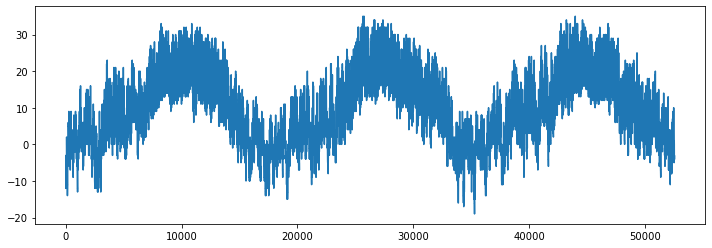

In [277]:
train['T'].plot(figsize=(12, 4))
plt.show()

In [278]:
# 그냥 속 시원하게 1월 1일부터 넣어봐..?
# 52560개, 1095일, 3년 딱 맞음.

new_df = pd.DataFrame(index=pd.date_range(start='2017-01-01', end='2019-12-31', freq='D'))

days = []
for i in range(len(new_df)):
    days.append(i)
    
new_df['Day'] = days

In [279]:
new_df

,Day
2017-01-01,0
2017-01-02,1
2017-01-03,2
2017-01-04,3
2017-01-05,4
...,...
2019-12-27,1090
2019-12-28,1091
2019-12-29,1092
2019-12-30,1093


대충 날짜를 때려 박겠습니다. 합쳐주는 건 나중에

## Step-2: Sun Angle

날짜를 맞춰 주었으니, 이제는 남중고도각을 만들어주어야겠습니다.

위에서 말했다시피 6월 21일인 하지에 75.9도,<br>
12월 22일인 동지에 28.9도, <br>
그리고 절기(15일)마다 3.9도씩 변화하기 때문에, 하루에 약 0.26도 변화한다고 볼 수 있습니다.

데이터가 하루에 48개씩 반복되기 때문에 앞서 사용했던 방법과 마찬가지로, 따로 만들어서 merge해주는 게 필요합니다.

In [280]:
# 위에서 만든 new_df 재활용쓰
new_df['Max_Angle'] = np.nan # 일단 nan으로 column 생성

In [281]:
# 1월 1일은 31.5도 입니다.
# 

angle = []
start = 31.24 # 0.26을 뺀 31.24를 0일의 기준으로 둡니다.
for i in range(172): # 1월 1일부터 하지인 6월 21일끼는 172일입니다.
    if start > 76:
        break
    else:
        start+=.26
        angle.append(start)
    
for i in range(184): # 6월 22일부터 동지인 12월 22일은 184일입니다.
    if start < 29:
        break
    else:
        start-=.256
        angle.append(start)
    
for i in range(9): # 12월 22일부터 말일인 12월 31일은 9일입니다.
    start+=.26
    angle.append(start)
        
len(angle)

365

In [282]:
new_df.Max_Angle = angle*3

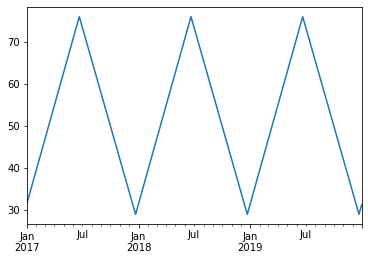

In [283]:
new_df.Max_Angle.plot()
plt.show()

아주 잘 그려졌습니다.

In [284]:
new_df[160:180]

,Day,Max_Angle
2017-06-10,160,73.100
2017-06-11,161,73.360
2017-06-12,162,73.620
2017-06-13,163,73.880
2017-06-14,164,74.140
2017-06-15,165,74.400
2017-06-16,166,74.660
2017-06-17,167,74.920
2017-06-18,168,75.180
2017-06-19,169,75.440


## Step-3: Sun Angle by half hour

거의 다 왔습니다. 이제 그 날의 남중고도각이 나왔으니, 시간별로 천정각을 구해줘야 합니다.

전에 썼던 방식을 그대로 차용하면 됩니다.

문제는 day마다 남중고도각이 다르기 때문에, day마다 max값을 뽑아서 0부터 max까지 일정한 간격으로 값을 넣어줘야 하는데, 이 과정이 정말 어렵습니다. 그래도 한 번 도전해봅시다.

In [285]:
# 먼저 만들어 둔 date와 max_angle을 합쳐줍니다.
train = pd.merge(train, new_df.reset_index(), how='outer', on=['Day'])
# column name을 보기 좋게 바꿔줍시다.
train.rename({'index':'Date'}, axis=1, inplace=True)

In [286]:
train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Date,Max_Angle
0,0,0.0,0.0,0,0,1.5,69.080002,-12,0.0,2017-01-01,31.5
1,0,0.5,0.5,0,0,1.5,69.059998,-12,0.0,2017-01-01,31.5
2,0,1.0,0.0,0,0,1.6,71.779999,-12,0.0,2017-01-01,31.5
3,0,1.5,0.5,0,0,1.6,71.750000,-12,0.0,2017-01-01,31.5
4,0,2.0,0.0,0,0,1.6,75.199997,-12,0.0,2017-01-01,31.5


In [287]:
def make_sun_angle(new_train, window=48):
    """
    definition:
    df를 하루 단위로 잘라서 해당 일자의 남중고도각에 맞춰 일출 시간과 일몰 시간에 대한
    이동각을 계산해서 각각 집어 넣어주는 함수입니다.
    이 함수를 통해 시간별 태양의 천정각을 추출할 수 있습니다.
    """
    new_train2 = []

    for h in range(int(new_train.shape[0]/window)):
        temp = new_train[(h)*window:(h+1)*window]
        temp = temp.reset_index(drop=True)

        # 일출부터 정오까지 angle 채우는 코드 ---------------------------------------------------------
        for m in range(temp.shape[0]): # morning 이니까 m으로 받겠습니다.
            if temp.DHI[m] > 0: # 처음부터 타고 내려갔을 때, DHI가 최초로 0을 넘는 순간.
                sunrise = temp.Hour[m] # 그 시간을 일출 시간으로 받는다.
                sunrise_idx = m-1 # 그 idx-1 번을 받는다.
                max_angle = temp.Max_Angle[m] # max_angle을 받는다.

                break # 받으면 멈춘다.
            else:
                pass

        count = ((12.5 - sunrise)/0.5)+1 # 기준시인 12.5에서 일출 시간을 빼고, 단위인 0.5로 나눈다. 1을 더해줘야 맞음.
        angle = max_angle / count # max_angle을 count로 나눠주면 0.5시간당 이동각이 나온다.

        for i in range(int(count)): # 이제 채워주자.
            temp.loc[sunrise_idx+i, 'Angle'] = i*angle # 일출 시간 idx부터 count 수만큼 angle을 채워준다.


        # 정오부터 일몰까지 angle 채우는 코드 ---------------------------------------------------------
        # 다 똑같지만, 정오부터 내려가기 때문에 24라는 lag을 준다.
        for d in range(temp.shape[0]): # 저녁이니까 d로 받습니다.
            lag = 24
            if temp.DHI[d+lag] < 1: # 정오부터 시작해서 최초로 DHI가 1보다 작아지는 순간.
                sunset = temp.Hour[d+lag]
                sunset_idx = d+1+lag
                max_angle = temp.Max_Angle[d+lag]

                break
            else:
                pass

        count = (sunset - 12.5)/0.5 # 일몰시간에서 12.5를 빼고 나눠준다.
        angle = max_angle / count # 마찬가지로 0.5시간당 이동각이 나온다.

        for k in range(int(count)):
            temp.loc[(sunset_idx-count-1)+k, 'Angle'] = max_angle - (k*angle) # 정오부터 채워줍니다.

        temp = temp.fillna(.0) # 채워지지 않는 시간은 night이므로 0으로 채워줍니다.

        new_train2.append(temp)
        
    new_train3 = pd.concat(new_train2)
    new_train3 = new_train3.reset_index(drop=True)

    return new_train3

In [288]:
train = make_sun_angle(train)

In [289]:
train[15:20]

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Date,Max_Angle,Angle
15,0,7.5,0.5,0,0,1.6,64.830002,-10,0.000000,2017-01-01,31.5,0.00
16,0,8.0,0.0,29,494,1.8,65.449997,-9,7.039287,2017-01-01,31.5,3.15
17,0,8.5,0.5,61,7,1.9,55.900002,-7,5.912871,2017-01-01,31.5,6.30
18,0,9.0,0.0,58,743,2.1,57.389999,-6,22.337267,2017-01-01,31.5,9.45
19,0,9.5,0.5,67,811,1.9,53.150002,-4,29.469528,2017-01-01,31.5,12.60


## Step-4 : GHI

이제 고대하던 GHI를 계산하기만 하면 됩니다. 아주 쉽습니다.

GHI = DHI + DNI*cos(k)

In [290]:
# 천정각에 의해 GHI를 출력하는 함수입니다.

def ghi_formula(DHI, DNI, theta):
    return (DHI + (DNI*np.cos((theta-90)*0.0174533)))

In [291]:
train['GHI'] = ghi_formula(train.DHI, train.DNI, train.Angle)

In [292]:
train[15:20]

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Date,Max_Angle,Angle,GHI
15,0,7.5,0.5,0,0,1.6,64.830002,-10,0.000000,2017-01-01,31.5,0.00,0.000000
16,0,8.0,0.0,29,494,1.8,65.449997,-9,7.039287,2017-01-01,31.5,3.15,56.145068
17,0,8.5,0.5,61,7,1.9,55.900002,-7,5.912871,2017-01-01,31.5,6.30,61.768136
18,0,9.0,0.0,58,743,2.1,57.389999,-6,22.337267,2017-01-01,31.5,9.45,179.990385
19,0,9.5,0.5,67,811,1.9,53.150002,-4,29.469528,2017-01-01,31.5,12.60,243.913711


드디어 GHI를 완성했습니다 ㅠㅠ 으헝허어어어엏엉

## Step-5: Distance

이제 테스트 데이터를 train데이터와의 유사도를 측정해서 값을 받아오기만 하면 끝이 납니다. 고생하셨습니다.

In [293]:
int(train.shape[0]/336)

156

In [294]:
# numpy array 연산으로 오차를 빠르게 계산합니다.
#np.mean(test.RH.values - test.RH.values)

# 한 단계씩 내려가면서 비교를 해야 합니다. cnn의 filter와 비슷합니다.

def find_test_periods(train, test, window=336):
    """
    definition:
    총 336개의 데이터를 가진 test table을 3년의 기간을 가진 train table과 비교하여,
    가장 오차가 적은 구간을 찾아 언제 날짜인지를 추정하게 해주는 함수.
    ['RH', 'T', 'TARGET'] 을 활용
    """
    
    err_box = {}
    
    for i in range(int(train.shape[0] / window)):
        # 각 변수별로 구간을 window 단위로 slicing 해서 numpy연산으로 오차를 계산해줍니다.
        err_rh = np.mean(np.abs(train.RH[(i*window):((i+1)*window)].values - test.RH.values))
        err_t = np.mean(np.abs(train['T'][(i*window):((i+1)*window)].values - test['T'].values))
        err_tg = np.mean(np.abs(train.TARGET[(i*window):((i+1)*window)].values - test.TARGET.values))

        # 다시 세 값의 평균을 구합니다.
        err_mean = np.mean(err_rh + err_t + err_tg)

        # err_box에 오차값과 시작점 idx를 집어 넣습니다.
        err_box[err_mean]=i


    print("Minimum Loss: ", min(err_box))
    print("Minumum Index: ", err_box[min(err_box)])
    
    # 사실 loss는 상관없고요. idx만 받으면 됩니다.
    idx = err_box[min(err_box)]
                  
    # 이제 값을 받아줍시다.
    test[['Date', 'Max_Angle']] = train[idx:idx+window].reset_index()[['Date', 'Max_Angle']]
     
    return test

드디어 완성했습니다!!!!!!

기존의 유사도 측정 방식이 문제가 있는 것 같습니다. 위의 함수는 기각시키고, 새로운 방법을 가져오겠습니다.

1. 일단 train 데이터 기준으로 train과 test를 표준화 시킨다. 그렇게 하면 DHI도 투입이 가능합니다.
2. 그냥 평균으로 비교하는 게 아니라, 코사인 유사도로 측정해봅니다.

In [295]:
def cosine_test_periods(train, test, window=336):
    """
    definition:
    총 336개의 데이터를 가진 test table을 3년의 기간을 가진 train table과 비교하여,
    가장 오차가 적은 구간을 찾아 언제 날짜인지를 추정하게 해주는 함수.
    표준화를 시켜서, 코사인 유사도로 측정
    """
    
    err_box = {}
    
    # 각 변수를 받아서 표준화를 먼저 해줍니다.
    rh_mean = np.mean(train.RH)
    rh_std = np.std(train.RH)
    t_mean = np.mean(train['T'])
    t_std = np.std(train['T'])
    tg_mean = np.mean(train.TARGET)
    tg_std = np.std(train.TARGET)
    dhi_mean = np.mean(train.DHI)
    dhi_std = np.std(train.DHI)
    
    sd_tr_rh = (train.RH - rh_mean)/rh_std
    sd_tr_t = (train['T'] - t_mean)/t_std
    sd_tr_tg = (train.TARGET - tg_mean)/tg_std
    sd_tr_dhi = (train.DHI - dhi_mean)/dhi_std

    sd_te_rh = (test.RH - rh_mean)/rh_std
    sd_te_t = (test['T'] - t_mean)/t_std
    sd_te_tg = (test.TARGET - tg_mean)/tg_std
    sd_te_dhi = (test.DHI - dhi_mean)/dhi_std
    
    for i in range(int(train.shape[0] / window)):

        # 행렬로 받아서 코사인 유사도를 구해줍니다.
        sd_tr_matrix = np.column_stack((sd_tr_rh[(i*window):((i+1)*window)],
                                        sd_tr_t[(i*window):((i+1)*window)],
                                        sd_tr_tg[(i*window):((i+1)*window)],
                                        sd_tr_dhi[(i*window):((i+1)*window)]))
        sd_te_matrix = np.column_stack((sd_te_rh, sd_te_t, sd_te_tg, sd_te_dhi))
        
        err = distance.cosine(np.hstack(sd_tr_matrix), np.hstack(sd_te_matrix))
        
        # err_box에 오차값과 시작점 idx를 집어 넣습니다.
        err_box[err]=i


    print("Minimum Loss: ", min(err_box))
    print("Minumum Index: ", err_box[min(err_box)])
    
    # 사실 loss는 상관없고요. idx만 받으면 됩니다.
    idx = err_box[min(err_box)]
                  
    # 이제 값을 받아줍시다.
    test[['Date', 'Max_Angle']] = train[idx:idx+window].reset_index()[['Date', 'Max_Angle']]
     
    return test

In [296]:
cosine_test_periods(train, test)

Minimum Loss:  0.1691339976385522
Minumum Index:  154


,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Date,Max_Angle
0,0,0,0,0,0,2.7,34.419998,0.0,0.0,2017-01-04,32.28
1,0,0,30,0,0,2.7,34.169998,0.1,0.0,2017-01-04,32.28
2,0,1,0,0,0,2.7,34.230000,0.2,0.0,2017-01-04,32.28
3,0,1,30,0,0,2.7,33.990002,0.3,0.0,2017-01-04,32.28
4,0,2,0,0,0,2.8,33.970001,0.4,0.0,2017-01-04,32.28
...,...,...,...,...,...,...,...,...,...,...,...
331,6,21,30,0,0,3.6,56.090000,-8.0,0.0,2017-01-11,34.10
332,6,22,0,0,0,3.4,53.540001,-8.2,0.0,2017-01-11,34.10
333,6,22,30,0,0,3.4,53.889999,-8.3,0.0,2017-01-11,34.10
334,6,23,0,0,0,3.4,51.959999,-8.4,0.0,2017-01-11,34.10


## Step-6: Deploy

이제 test를 불러오면서 해당 함수를 적용시켜주면 됩니다.

먼저 train set을 shift 해줍니다.

### train test set

In [297]:
train.columns

Index(['Day', 'Hour', 'Minute', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET',
       'Date', 'Max_Angle', 'Angle', 'GHI'],
      dtype='object')

In [298]:
shifted_columns = ['DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', 'Angle', 'GHI']
lags = [48, 96, 144, 192, 240] # 뒤에서부터 하나씩 줄인다.

In [299]:
def shift_columns(data, shifted_columns, lags):
    
    temp = data.copy()
    for lag in lags:
        for col in shifted_columns:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag)
            
    return temp

In [300]:
# shift되지 않은 train은 test를 만들기 위해 필요합니다.
# 새로운 df로 받아줍시다.
new_train = shift_columns(train, shifted_columns, lags)
new_train.shape

(52560, 53)

In [301]:
new_train['TARGET_1'] = new_train.TARGET.shift(-48)
new_train['TARGET_2'] = new_train.TARGET_1.shift(-48)

In [302]:
# 학습에 쓰지 않을 변수들은 버려줍니다.
new_train.drop(['Day', 'Minute', 'Date', 'Max_Angle'], axis=1, inplace=True)

In [303]:
new_train.dropna(inplace=True)
new_train.shape

(52224, 51)

In [304]:
new_train.head()

,Hour,DHI,DNI,WS,RH,T,TARGET,Angle,GHI,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,TARGET_lag_48,Angle_lag_48,GHI_lag_48,DHI_lag_96,DNI_lag_96,WS_lag_96,RH_lag_96,T_lag_96,TARGET_lag_96,Angle_lag_96,GHI_lag_96,DHI_lag_144,DNI_lag_144,WS_lag_144,RH_lag_144,T_lag_144,TARGET_lag_144,Angle_lag_144,GHI_lag_144,DHI_lag_192,DNI_lag_192,WS_lag_192,RH_lag_192,T_lag_192,TARGET_lag_192,Angle_lag_192,GHI_lag_192,DHI_lag_240,DNI_lag_240,WS_lag_240,RH_lag_240,T_lag_240,TARGET_lag_240,Angle_lag_240,GHI_lag_240,TARGET_1,TARGET_2
240,0.0,0,0,1.5,77.410004,1,0.0,0.0,0.0,0.0,0.0,2.1,72.099998,-5.0,0.0,0.0,0.0,0.0,0.0,1.8,77.760002,-14.0,0.0,0.0,0.0,0.0,0.0,2.2,73.800003,-8.0,0.0,0.0,0.0,0.0,0.0,1.6,90.660004,-10.0,0.0,0.0,0.0,0.0,0.0,1.5,69.080002,-12.0,0.0,0.0,0.0,0.0,0.0
241,0.5,0,0,1.7,77.419998,1,0.0,0.0,0.0,0.0,0.0,2.0,72.099998,-5.0,0.0,0.0,0.0,0.0,0.0,2.0,77.769997,-13.0,0.0,0.0,0.0,0.0,0.0,2.1,68.199997,-8.0,0.0,0.0,0.0,0.0,0.0,1.6,90.680000,-10.0,0.0,0.0,0.0,0.0,0.0,1.5,69.059998,-12.0,0.0,0.0,0.0,0.0,0.0
242,1.0,0,0,1.9,76.769997,1,0.0,0.0,0.0,0.0,0.0,2.0,72.139999,-5.0,0.0,0.0,0.0,0.0,0.0,2.2,77.690002,-13.0,0.0,0.0,0.0,0.0,0.0,2.1,69.059998,-8.0,0.0,0.0,0.0,0.0,0.0,1.6,88.110001,-11.0,0.0,0.0,0.0,0.0,0.0,1.6,71.779999,-12.0,0.0,0.0,0.0,0.0,0.0
243,1.5,0,0,2.0,76.769997,1,0.0,0.0,0.0,0.0,0.0,2.0,72.110001,-5.0,0.0,0.0,0.0,0.0,0.0,2.2,71.570000,-13.0,0.0,0.0,0.0,0.0,0.0,2.1,69.040001,-8.0,0.0,0.0,0.0,0.0,0.0,1.6,88.110001,-11.0,0.0,0.0,0.0,0.0,0.0,1.6,71.750000,-12.0,0.0,0.0,0.0,0.0,0.0
244,2.0,0,0,2.2,76.389999,1,0.0,0.0,0.0,0.0,0.0,2.0,72.940002,-5.0,0.0,0.0,0.0,0.0,0.0,2.2,72.620003,-13.0,0.0,0.0,0.0,0.0,0.0,2.2,69.379997,-8.0,0.0,0.0,0.0,0.0,0.0,1.6,90.849998,-11.0,0.0,0.0,0.0,0.0,0.0,1.6,75.199997,-12.0,0.0,0.0,0.0,0.0,0.0


In [305]:
train['TARGET_1'] = train.TARGET.shift(-48)
train['TARGET_2'] = train.TARGET_1.shift(-48)

In [306]:
train = train.dropna()

In [307]:
train.tail()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,Date,Max_Angle,Angle,GHI,TARGET_1,TARGET_2
52459,1092,21.5,0.5,0,0,3.5,55.970001,-1,0.0,2019-12-29,30.676,0.0,0.0,0.0,0.0
52460,1092,22.0,0.0,0,0,3.9,54.230000,-2,0.0,2019-12-29,30.676,0.0,0.0,0.0,0.0
52461,1092,22.5,0.5,0,0,4.1,54.209999,-2,0.0,2019-12-29,30.676,0.0,0.0,0.0,0.0
52462,1092,23.0,0.0,0,0,4.3,56.459999,-2,0.0,2019-12-29,30.676,0.0,0.0,0.0,0.0
52463,1092,23.5,0.5,0,0,4.1,56.439999,-2,0.0,2019-12-29,30.676,0.0,0.0,0.0,0.0


다음으로 test를 불러와줍니다.

In [268]:
# test set load

df_test = []

for i in range(81):
    file_path = TEST_PATH + '/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    # 전처리 코드 아래에 넣기---------------------------------------------------------------
    temp = sum_hour_minute(temp) # hour와 min 합치고
    temp = cosine_test_periods(train, temp) # train으로부터 date와 max_angle 받아오고
    temp = make_sun_angle(temp) # 일별 sun_angle 계산하고
    temp['GHI'] = ghi_formula(temp.DHI, temp.DNI, temp.Angle) # ghi 계산하고
    # shift 코드 아래에 넣기 --------------------------------------------------------------
    temp = shift_columns(temp, shifted_columns, lags)
    
    df_test.append(temp[-48:]) # 뒤에서 48개, 즉 마지막 하루만 받아준다.

X_test = pd.concat(df_test)
print(X_test.shape)

Minimum Loss:  0.16878709323228724
Minumum Index:  154
Minimum Loss:  0.10864619878892279
Minumum Index:  100
Minimum Loss:  0.09878576422174945
Minumum Index:  55
Minimum Loss:  0.08391359186629388
Minumum Index:  112
Minimum Loss:  0.16222310876404678
Minumum Index:  59
Minimum Loss:  0.11236129625702795
Minumum Index:  30
Minimum Loss:  0.14821753312648445
Minumum Index:  131
Minimum Loss:  0.12902295985688206
Minumum Index:  81
Minimum Loss:  0.13645247941570549
Minumum Index:  107
Minimum Loss:  0.10744281760765906
Minumum Index:  139
Minimum Loss:  0.1850341380137539
Minumum Index:  9
Minimum Loss:  0.1263017961147952
Minumum Index:  29
Minimum Loss:  0.166339424911078
Minumum Index:  60
Minimum Loss:  0.0848911004063918
Minumum Index:  94
Minimum Loss:  0.12697952322755002
Minumum Index:  79
Minimum Loss:  0.18550014183334962
Minumum Index:  123
Minimum Loss:  0.1615783306928582
Minumum Index:  45
Minimum Loss:  0.21199696554136527
Minumum Index:  110
Minimum Loss:  0.1257599770

In [269]:
# test set load

df_test = []

for i in range(81):
    file_path = TEST_PATH + '/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    # 전처리 코드 아래에 넣기---------------------------------------------------------------
    temp = sum_hour_minute(temp) # hour와 min 합치고
    temp = cosine_test_periods(train, temp) # train으로부터 date와 max_angle 받아오고
    temp = make_sun_angle(temp) # 일별 sun_angle 계산하고
    temp['GHI'] = ghi_formula(temp.DHI, temp.DNI, temp.Angle) # ghi 계산하고
    # shift 코드 아래에 넣기 --------------------------------------------------------------
    #temp = shift_columns(temp, shifted_columns, lags)
    
    df_test.append(temp[-48:]) # 뒤에서 48개, 즉 마지막 하루만 받아준다.

X_test_2 = pd.concat(df_test)
print(X_test_2.shape)

Minimum Loss:  0.16878709323228724
Minumum Index:  154
Minimum Loss:  0.10864619878892279
Minumum Index:  100
Minimum Loss:  0.09878576422174945
Minumum Index:  55
Minimum Loss:  0.08391359186629388
Minumum Index:  112
Minimum Loss:  0.16222310876404678
Minumum Index:  59
Minimum Loss:  0.11236129625702795
Minumum Index:  30
Minimum Loss:  0.14821753312648445
Minumum Index:  131
Minimum Loss:  0.12902295985688206
Minumum Index:  81
Minimum Loss:  0.13645247941570549
Minumum Index:  107
Minimum Loss:  0.10744281760765906
Minumum Index:  139
Minimum Loss:  0.1850341380137539
Minumum Index:  9
Minimum Loss:  0.1263017961147952
Minumum Index:  29
Minimum Loss:  0.166339424911078
Minumum Index:  60
Minimum Loss:  0.0848911004063918
Minumum Index:  94
Minimum Loss:  0.12697952322755002
Minumum Index:  79
Minimum Loss:  0.18550014183334962
Minumum Index:  123
Minimum Loss:  0.1615783306928582
Minumum Index:  45
Minimum Loss:  0.21199696554136527
Minumum Index:  110
Minimum Loss:  0.1257599770

아래는 비교용으로 find_test_periods 쓴 것

In [106]:
# test set load

df_test = []

for i in range(81):
    file_path = TEST_PATH + '/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    # 전처리 코드 아래에 넣기---------------------------------------------------------------
    temp = sum_hour_minute(temp) # hour와 min 합치고
    temp = find_test_periods(train, temp) # train으로부터 date와 max_angle 받아오고
    temp = make_sun_angle(temp) # 일별 sun_angle 계산하고
    temp['GHI'] = ghi_formula(temp.DHI, temp.DNI, temp.Angle) # ghi 계산하고
    # shift 코드 아래에 넣기 --------------------------------------------------------------
    temp = shift_columns(temp, shifted_columns, lags)
    
    df_test.append(temp[-48:]) # 뒤에서 48개, 즉 마지막 하루만 받아준다.

X_test = pd.concat(df_test)
print(X_test.shape)

Minimum Loss:  15.764643626947894
Minumum Index:  154
Minimum Loss:  18.416308650798083
Minumum Index:  107
Minimum Loss:  13.753644149894539
Minumum Index:  55
Minimum Loss:  13.917596308081041
Minumum Index:  112
Minimum Loss:  18.448577114979646
Minumum Index:  6
Minimum Loss:  18.228686925922865
Minumum Index:  128
Minimum Loss:  23.518504510164924
Minumum Index:  131
Minimum Loss:  20.418757911457003
Minumum Index:  81
Minimum Loss:  15.975890142836517
Minumum Index:  54
Minimum Loss:  17.951932873610403
Minumum Index:  139
Minimum Loss:  18.864142477451757
Minumum Index:  60
Minimum Loss:  18.612568863763407
Minumum Index:  29
Minimum Loss:  20.367147004760568
Minumum Index:  60
Minimum Loss:  17.480693498974457
Minumum Index:  94
Minimum Loss:  22.91556158392429
Minumum Index:  79
Minimum Loss:  20.934139581909285
Minumum Index:  123
Minimum Loss:  16.482812278835393
Minumum Index:  45
Minimum Loss:  19.52865251452157
Minumum Index:  110
Minimum Loss:  17.900222358880555
Minumum

In [107]:
# test set load

df_test = []

for i in range(81):
    file_path = TEST_PATH + '/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    # 전처리 코드 아래에 넣기---------------------------------------------------------------
    temp = sum_hour_minute(temp) # hour와 min 합치고
    temp = find_test_periods(train, temp) # train으로부터 date와 max_angle 받아오고
    temp = make_sun_angle(temp) # 일별 sun_angle 계산하고
    temp['GHI'] = ghi_formula(temp.DHI, temp.DNI, temp.Angle) # ghi 계산하고
    # shift 코드 아래에 넣기 --------------------------------------------------------------
    #temp = shift_columns(temp, shifted_columns, lags)
    
    df_test.append(temp[-48:]) # 뒤에서 48개, 즉 마지막 하루만 받아준다.

X_test_2 = pd.concat(df_test)
print(X_test_2.shape)

Minimum Loss:  15.764643626947894
Minumum Index:  154
Minimum Loss:  18.416308650798083
Minumum Index:  107
Minimum Loss:  13.753644149894539
Minumum Index:  55
Minimum Loss:  13.917596308081041
Minumum Index:  112
Minimum Loss:  18.448577114979646
Minumum Index:  6
Minimum Loss:  18.228686925922865
Minumum Index:  128
Minimum Loss:  23.518504510164924
Minumum Index:  131
Minimum Loss:  20.418757911457003
Minumum Index:  81
Minimum Loss:  15.975890142836517
Minumum Index:  54
Minimum Loss:  17.951932873610403
Minumum Index:  139
Minimum Loss:  18.864142477451757
Minumum Index:  60
Minimum Loss:  18.612568863763407
Minumum Index:  29
Minimum Loss:  20.367147004760568
Minumum Index:  60
Minimum Loss:  17.480693498974457
Minumum Index:  94
Minimum Loss:  22.91556158392429
Minumum Index:  79
Minimum Loss:  20.934139581909285
Minumum Index:  123
Minimum Loss:  16.482812278835393
Minumum Index:  45
Minimum Loss:  19.52865251452157
Minumum Index:  110
Minimum Loss:  17.900222358880555
Minumum

### train predict

In [308]:
train = train.drop(['Day', 'Minute', 'Date', 'Max_Angle'], axis=1)
#train = train.drop(['GHI'], axis=1)
train.head()

,Hour,DHI,DNI,WS,RH,T,TARGET,Angle,GHI,TARGET_1,TARGET_2
0,0.0,0,0,1.5,69.080002,-12,0.0,0.0,0.0,0.0,0.0
1,0.5,0,0,1.5,69.059998,-12,0.0,0.0,0.0,0.0,0.0
2,1.0,0,0,1.6,71.779999,-12,0.0,0.0,0.0,0.0,0.0
3,1.5,0,0,1.6,71.750000,-12,0.0,0.0,0.0,0.0,0.0
4,2.0,0,0,1.6,75.199997,-12,0.0,0.0,0.0,0.0,0.0


In [309]:
new_train

,Hour,DHI,DNI,WS,RH,T,TARGET,Angle,GHI,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,TARGET_lag_48,Angle_lag_48,GHI_lag_48,DHI_lag_96,DNI_lag_96,WS_lag_96,RH_lag_96,T_lag_96,TARGET_lag_96,Angle_lag_96,GHI_lag_96,DHI_lag_144,DNI_lag_144,WS_lag_144,RH_lag_144,T_lag_144,TARGET_lag_144,Angle_lag_144,GHI_lag_144,DHI_lag_192,DNI_lag_192,WS_lag_192,RH_lag_192,T_lag_192,TARGET_lag_192,Angle_lag_192,GHI_lag_192,DHI_lag_240,DNI_lag_240,WS_lag_240,RH_lag_240,T_lag_240,TARGET_lag_240,Angle_lag_240,GHI_lag_240,TARGET_1,TARGET_2
240,0.0,0,0,1.5,77.410004,1,0.0,0.0,0.0,0.0,0.0,2.1,72.099998,-5.0,0.0,0.0,0.0,0.0,0.0,1.8,77.760002,-14.0,0.0,0.0,0.0,0.0,0.0,2.2,73.800003,-8.0,0.0,0.0,0.0,0.0,0.0,1.6,90.660004,-10.0,0.0,0.0,0.0,0.0,0.0,1.5,69.080002,-12.0,0.0,0.0,0.0,0.0,0.0
241,0.5,0,0,1.7,77.419998,1,0.0,0.0,0.0,0.0,0.0,2.0,72.099998,-5.0,0.0,0.0,0.0,0.0,0.0,2.0,77.769997,-13.0,0.0,0.0,0.0,0.0,0.0,2.1,68.199997,-8.0,0.0,0.0,0.0,0.0,0.0,1.6,90.680000,-10.0,0.0,0.0,0.0,0.0,0.0,1.5,69.059998,-12.0,0.0,0.0,0.0,0.0,0.0
242,1.0,0,0,1.9,76.769997,1,0.0,0.0,0.0,0.0,0.0,2.0,72.139999,-5.0,0.0,0.0,0.0,0.0,0.0,2.2,77.690002,-13.0,0.0,0.0,0.0,0.0,0.0,2.1,69.059998,-8.0,0.0,0.0,0.0,0.0,0.0,1.6,88.110001,-11.0,0.0,0.0,0.0,0.0,0.0,1.6,71.779999,-12.0,0.0,0.0,0.0,0.0,0.0
243,1.5,0,0,2.0,76.769997,1,0.0,0.0,0.0,0.0,0.0,2.0,72.110001,-5.0,0.0,0.0,0.0,0.0,0.0,2.2,71.570000,-13.0,0.0,0.0,0.0,0.0,0.0,2.1,69.040001,-8.0,0.0,0.0,0.0,0.0,0.0,1.6,88.110001,-11.0,0.0,0.0,0.0,0.0,0.0,1.6,71.750000,-12.0,0.0,0.0,0.0,0.0,0.0
244,2.0,0,0,2.2,76.389999,1,0.0,0.0,0.0,0.0,0.0,2.0,72.940002,-5.0,0.0,0.0,0.0,0.0,0.0,2.2,72.620003,-13.0,0.0,0.0,0.0,0.0,0.0,2.2,69.379997,-8.0,0.0,0.0,0.0,0.0,0.0,1.6,90.849998,-11.0,0.0,0.0,0.0,0.0,0.0,1.6,75.199997,-12.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52459,21.5,0,0,3.5,55.970001,-1,0.0,0.0,0.0,0.0,0.0,3.3,61.599998,-1.0,0.0,0.0,0.0,0.0,0.0,2.7,57.009998,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,84.849998,-8.0,0.0,0.0,0.0,0.0,0.0,1.7,79.269997,-4.0,0.0,0.0,0.0,0.0,0.0,1.6,48.889999,-3.0,0.0,0.0,0.0,0.0,0.0
52460,22.0,0,0,3.9,54.230000,-2,0.0,0.0,0.0,0.0,0.0,3.3,58.410000,-1.0,0.0,0.0,0.0,0.0,0.0,2.7,56.820000,-1.0,0.0,0.0,0.0,0.0,0.0,1.2,82.260002,-8.0,0.0,0.0,0.0,0.0,0.0,1.7,76.800003,-4.0,0.0,0.0,0.0,0.0,0.0,1.5,51.959999,-3.0,0.0,0.0,0.0,0.0,0.0
52461,22.5,0,0,4.1,54.209999,-2,0.0,0.0,0.0,0.0,0.0,3.3,58.380001,-1.0,0.0,0.0,0.0,0.0,0.0,2.6,56.820000,-1.0,0.0,0.0,0.0,0.0,0.0,1.3,82.250000,-8.0,0.0,0.0,0.0,0.0,0.0,1.6,76.800003,-4.0,0.0,0.0,0.0,0.0,0.0,1.4,51.950001,-3.0,0.0,0.0,0.0,0.0,0.0
52462,23.0,0,0,4.3,56.459999,-2,0.0,0.0,0.0,0.0,0.0,3.4,55.939999,-1.0,0.0,0.0,0.0,0.0,0.0,2.6,56.900002,-1.0,0.0,0.0,0.0,0.0,0.0,1.5,81.139999,-8.0,0.0,0.0,0.0,0.0,0.0,1.6,80.500000,-5.0,0.0,0.0,0.0,0.0,0.0,1.3,56.099998,-3.0,0.0,0.0,0.0,0.0,0.0


In [310]:
X_test = X_test.drop(['Day', 'Minute', 'Date', 'Max_Angle'], axis=1)
X_test.head()

,Hour,DHI,DNI,WS,RH,T,TARGET,Angle,GHI,DHI_lag_48,DNI_lag_48,WS_lag_48,RH_lag_48,T_lag_48,TARGET_lag_48,Angle_lag_48,GHI_lag_48,DHI_lag_96,DNI_lag_96,WS_lag_96,RH_lag_96,T_lag_96,TARGET_lag_96,Angle_lag_96,GHI_lag_96,DHI_lag_144,DNI_lag_144,WS_lag_144,RH_lag_144,T_lag_144,TARGET_lag_144,Angle_lag_144,GHI_lag_144,DHI_lag_192,DNI_lag_192,WS_lag_192,RH_lag_192,T_lag_192,TARGET_lag_192,Angle_lag_192,GHI_lag_192,DHI_lag_240,DNI_lag_240,WS_lag_240,RH_lag_240,T_lag_240,TARGET_lag_240,Angle_lag_240,GHI_lag_240
288,0.0,0,0,0.8,80.92,-2.8,0.0,0.0,0.0,0.0,0.0,2.1,52.83,-4.4,0.0,0.0,0.0,0.0,0.0,2.4,57.25,-6.0,0.0,0.0,0.0,0.0,0.0,1.1,59.09,0.1,0.0,0.0,0.0,0.0,0.0,1.3,40.27,3.1,0.0,0.0,0.0,0.0,0.0,1.7,26.93,3.6,0.0,0.0,0.0
289,0.5,0,0,0.9,81.53,-2.9,0.0,0.0,0.0,0.0,0.0,2.0,54.44,-4.8,0.0,0.0,0.0,0.0,0.0,2.4,57.25,-6.0,0.0,0.0,0.0,0.0,0.0,1.2,61.20,-0.4,0.0,0.0,0.0,0.0,0.0,1.3,40.55,3.0,0.0,0.0,0.0,0.0,0.0,1.7,27.12,3.5,0.0,0.0,0.0
290,1.0,0,0,1.0,79.91,-3.0,0.0,0.0,0.0,0.0,0.0,1.9,52.78,-5.1,0.0,0.0,0.0,0.0,0.0,2.5,55.26,-6.1,0.0,0.0,0.0,0.0,0.0,1.3,65.76,-0.8,0.0,0.0,0.0,0.0,0.0,1.2,40.27,2.9,0.0,0.0,0.0,0.0,0.0,1.7,28.00,3.4,0.0,0.0,0.0
291,1.5,0,0,0.9,79.91,-3.0,0.0,0.0,0.0,0.0,0.0,1.8,53.59,-5.3,0.0,0.0,0.0,0.0,0.0,2.5,55.26,-6.1,0.0,0.0,0.0,0.0,0.0,1.4,66.24,-0.9,0.0,0.0,0.0,0.0,0.0,1.2,40.56,2.8,0.0,0.0,0.0,0.0,0.0,1.7,28.40,3.2,0.0,0.0,0.0
292,2.0,0,0,0.9,77.20,-3.0,0.0,0.0,0.0,0.0,0.0,1.7,52.63,-5.5,0.0,0.0,0.0,0.0,0.0,2.6,54.25,-6.0,0.0,0.0,0.0,0.0,0.0,1.5,69.70,-1.0,0.0,0.0,0.0,0.0,0.0,1.2,41.81,2.6,0.0,0.0,0.0,0.0,0.0,1.7,30.53,3.0,0.0,0.0,0.0


In [311]:
X_test_2 = X_test_2.drop(['Day', 'Minute', 'Date', 'Max_Angle'], axis=1)
#X_test_2 = X_test_2.drop(['GHI'], axis=1)
X_test_2.head()

,Hour,DHI,DNI,WS,RH,T,TARGET,Angle,GHI
288,0.0,0,0,0.8,80.92,-2.8,0.0,0.0,0.0
289,0.5,0,0,0.9,81.53,-2.9,0.0,0.0,0.0
290,1.0,0,0,1.0,79.91,-3.0,0.0,0.0,0.0
291,1.5,0,0,0.9,79.91,-3.0,0.0,0.0,0.0
292,2.0,0,0,0.9,77.20,-3.0,0.0,0.0,0.0


In [312]:
X = train[:33600]
val = train[33600:]

In [313]:
def make_train_test_val(X, val, features):

    x_train = X[features]
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val[features]
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    print(x_train.shape)
    
    return x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2

In [314]:
x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2 = make_train_test_val(X, val, X.columns[:-2])

(33600, 9)


In [315]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', # quantile로 받아줘야 quatile regression이 가능합니다.
                          alpha=q, # 이건 나중에 quantile 받을 인자입니다.
                          n_estimators=10000, # 10000만번을 돌리겠다고? 미쳤어?
                          bagging_fraction=0.7,
                          learning_rate=0.027,
                          subsample=0.7)                   
                         
                         
    model.fit(X_train,
              Y_train,
              eval_metric = ['quantile'],
              eval_set=[(X_valid, Y_valid)],
              early_stopping_rounds=300, verbose=500) # 대신 얼리 스토핑을 넣었네요.

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles: # 9번 반복할 겁니다. quantile 마다.
        print(q)
        pred , model = LGBM(q, # 퀀틸 박아줍니다.
                            X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model) # 모델을 어펜드 해줍니다.
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1) #pred를 컨캣해줍니다.

    LGBM_actual_pred.columns=quantiles # 컬럼은 퀀틸로 박아줍니다.
    
    return LGBM_models, LGBM_actual_pred

In [316]:
# Target1
models_1, results_1 = train_data(x_train, y_train_1, x_val, y_val_1, X_test_2)

# Target2
models_2, results_2 = train_data(x_train, y_train_2, x_val, y_val_2, X_test_2)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[86]	valid_0's quantile: 1.37547
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[152]	valid_0's quantile: 2.20717
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[158]	valid_0's quantile: 2.60313
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.7087
Early stopping, best iteratio

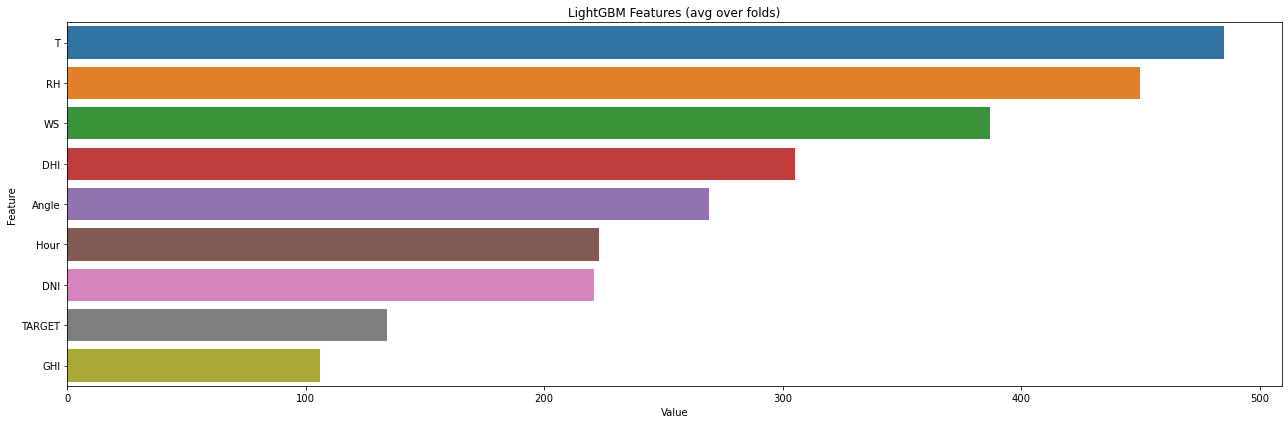

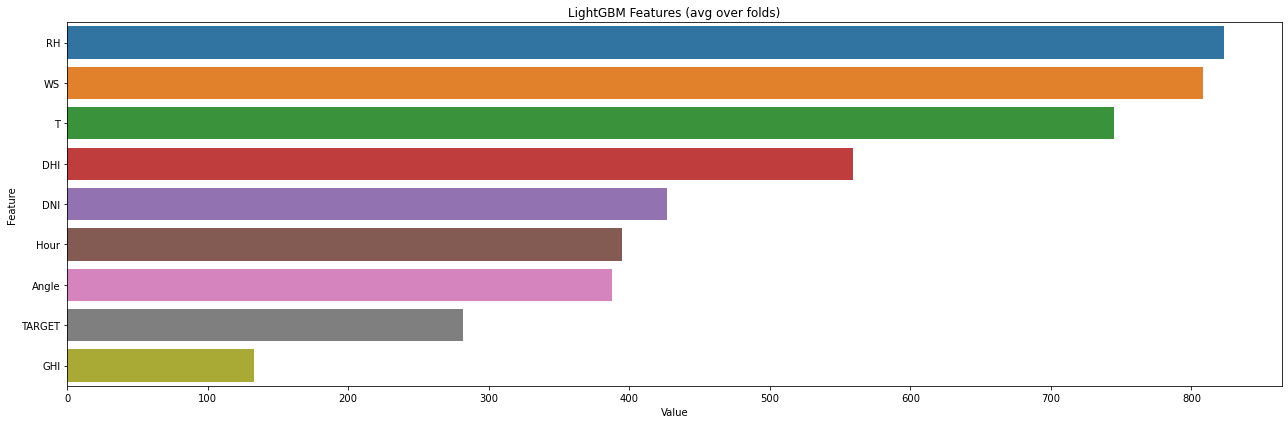

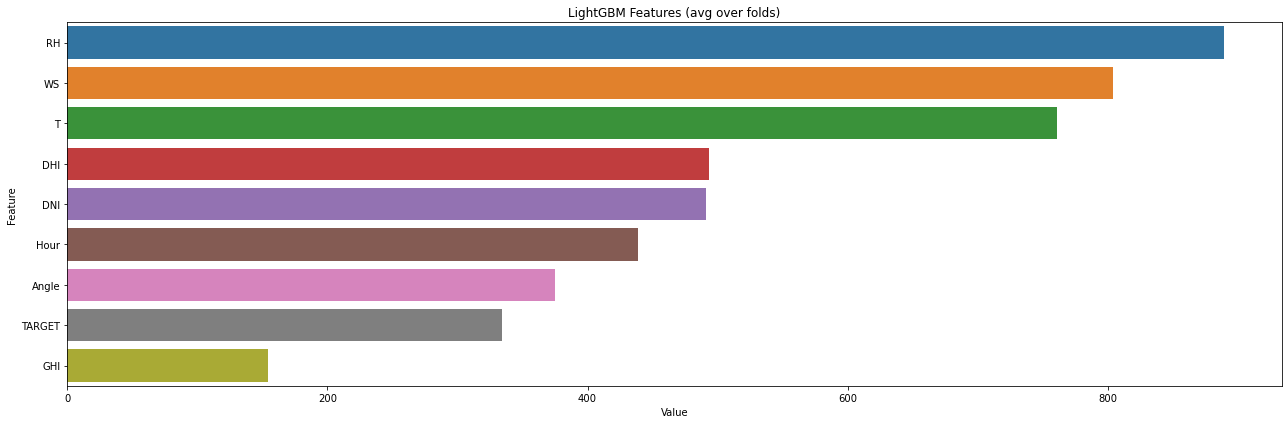

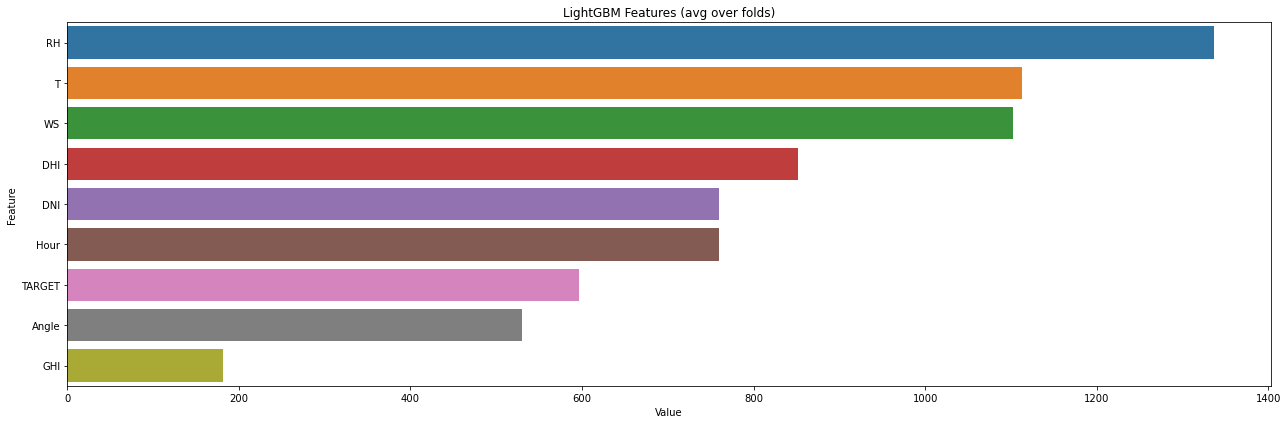

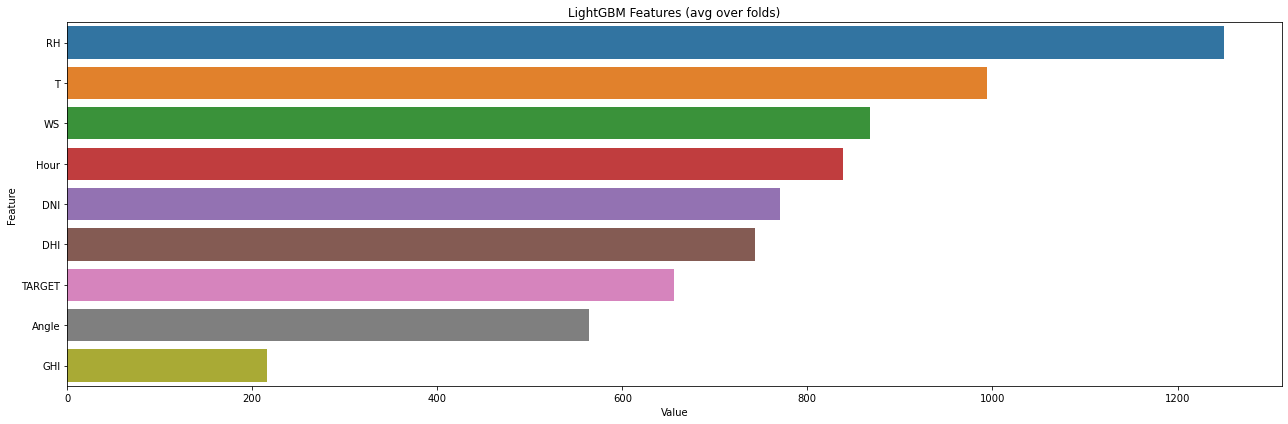

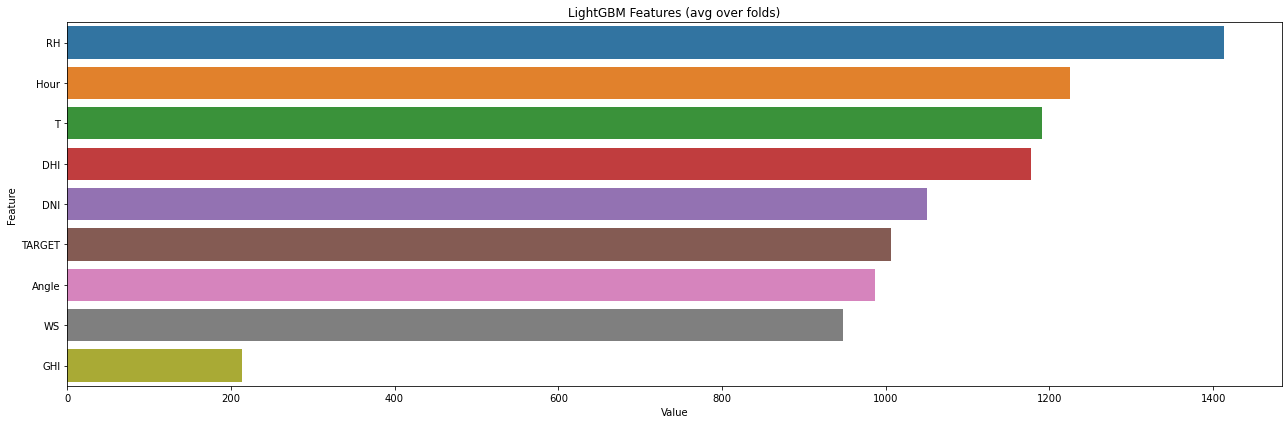

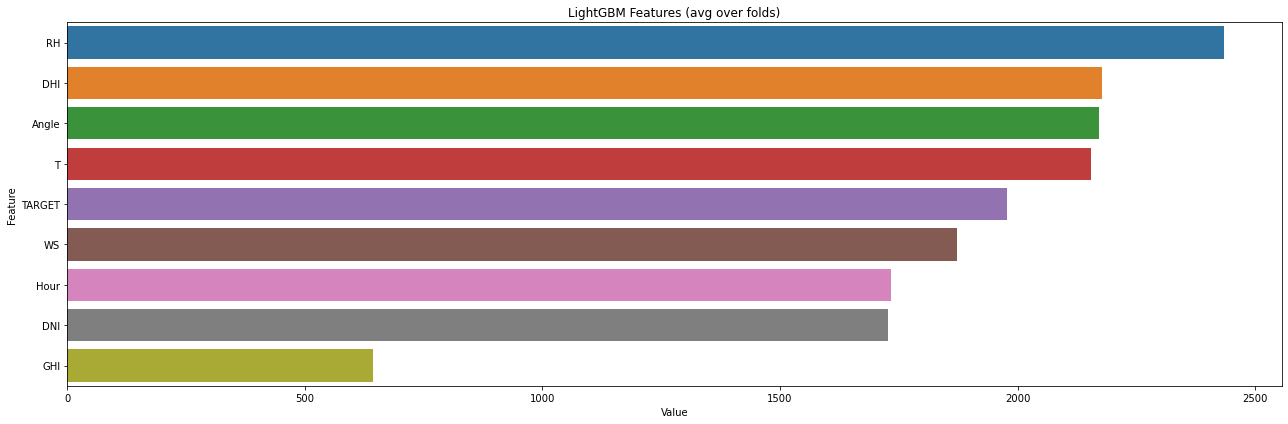

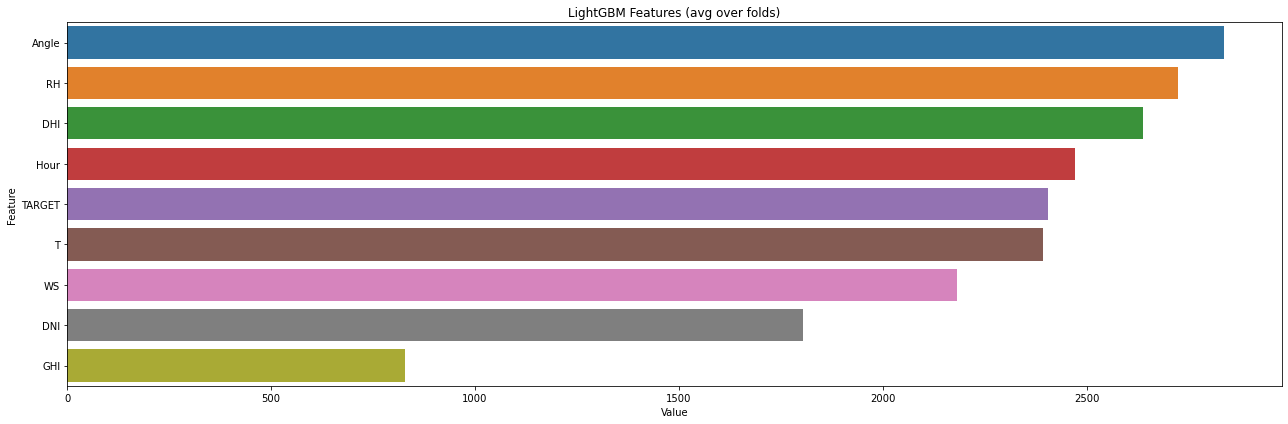

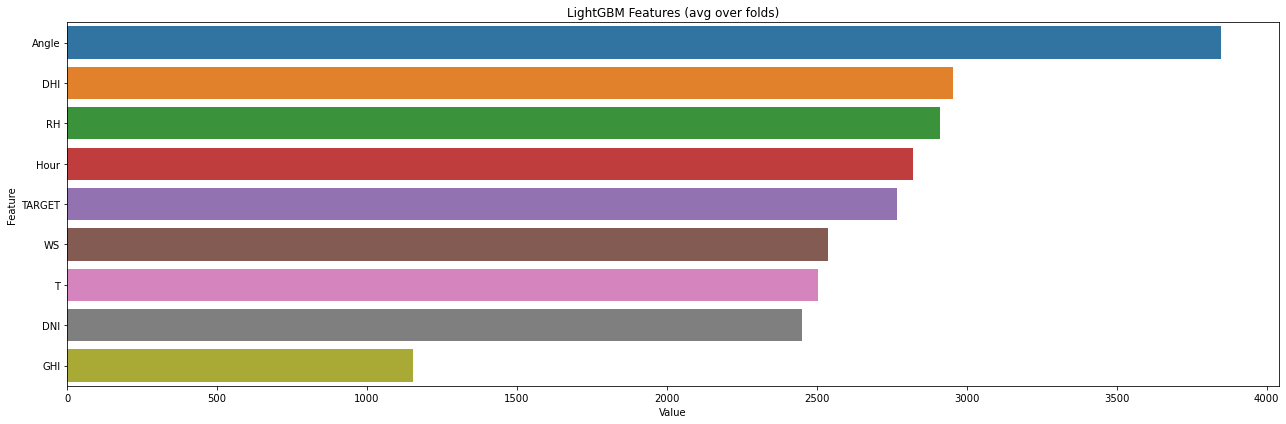

In [317]:
for i in range(len(models_1)):
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(models_1[i].feature_importances_,x_train.columns)),
                               columns=['Value','Feature'])

    plt.figure(figsize=(18, 6))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [318]:
# lag model 3 window decross model

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission[16:33]

#submission.to_csv('./submission/submission_210113-3_angle-nonshift.csv', index=False)

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
16,0.csv_Day7_8h00m,2.04,3.33,3.84,6.58,6.84,9.27,12.75,13.45,15.12
17,0.csv_Day7_8h30m,4.64,6.50,7.66,10.62,11.51,11.79,14.84,16.42,18.12
18,0.csv_Day7_9h00m,5.02,11.07,14.60,19.32,18.74,22.46,24.29,28.42,28.01
19,0.csv_Day7_9h30m,7.02,15.58,19.44,26.04,28.28,28.76,35.46,33.87,35.70
20,0.csv_Day7_10h00m,11.25,20.80,24.48,31.40,34.60,39.17,39.61,38.30,41.83
21,0.csv_Day7_10h30m,12.90,25.63,30.76,36.58,40.13,42.86,46.72,42.35,46.10
22,0.csv_Day7_11h00m,14.90,26.63,31.26,41.39,46.11,48.13,51.03,50.73,51.28
23,0.csv_Day7_11h30m,16.79,27.38,31.19,40.52,45.96,46.32,49.28,50.57,52.91
24,0.csv_Day7_12h00m,16.79,28.02,31.18,40.98,44.67,48.36,50.84,50.84,54.40
25,0.csv_Day7_12h30m,17.01,30.91,35.55,39.71,43.90,48.12,49.73,51.56,53.35


여기는 시프트 모델

In [319]:
X = new_train[:33600]
val = new_train[33600:]

In [320]:
def make_train_test_val(X, val, features):

    x_train = X[features]
    y_train_1 = X['TARGET_1']
    y_train_2 = X['TARGET_2']

    x_val = val[features]
    y_val_1 = val['TARGET_1']
    y_val_2 = val['TARGET_2']
    
    print(x_train.shape)
    
    return x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2

In [321]:
x_train, y_train_1, y_train_2, x_val, y_val_1, y_val_2 = make_train_test_val(X, val, X.columns[:-2])

(33600, 49)


In [322]:
# Target1
models_1, results_1 = train_data(x_train, y_train_1, x_val, y_val_1, X_test)

# Target2
models_2, results_2 = train_data(x_train, y_train_2, x_val, y_val_2, X_test)

0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[99]	valid_0's quantile: 1.38754
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[154]	valid_0's quantile: 2.22597
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.64917
Early stopping, best iteration is:
[339]	valid_0's quantile: 2.64275
0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.7 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.

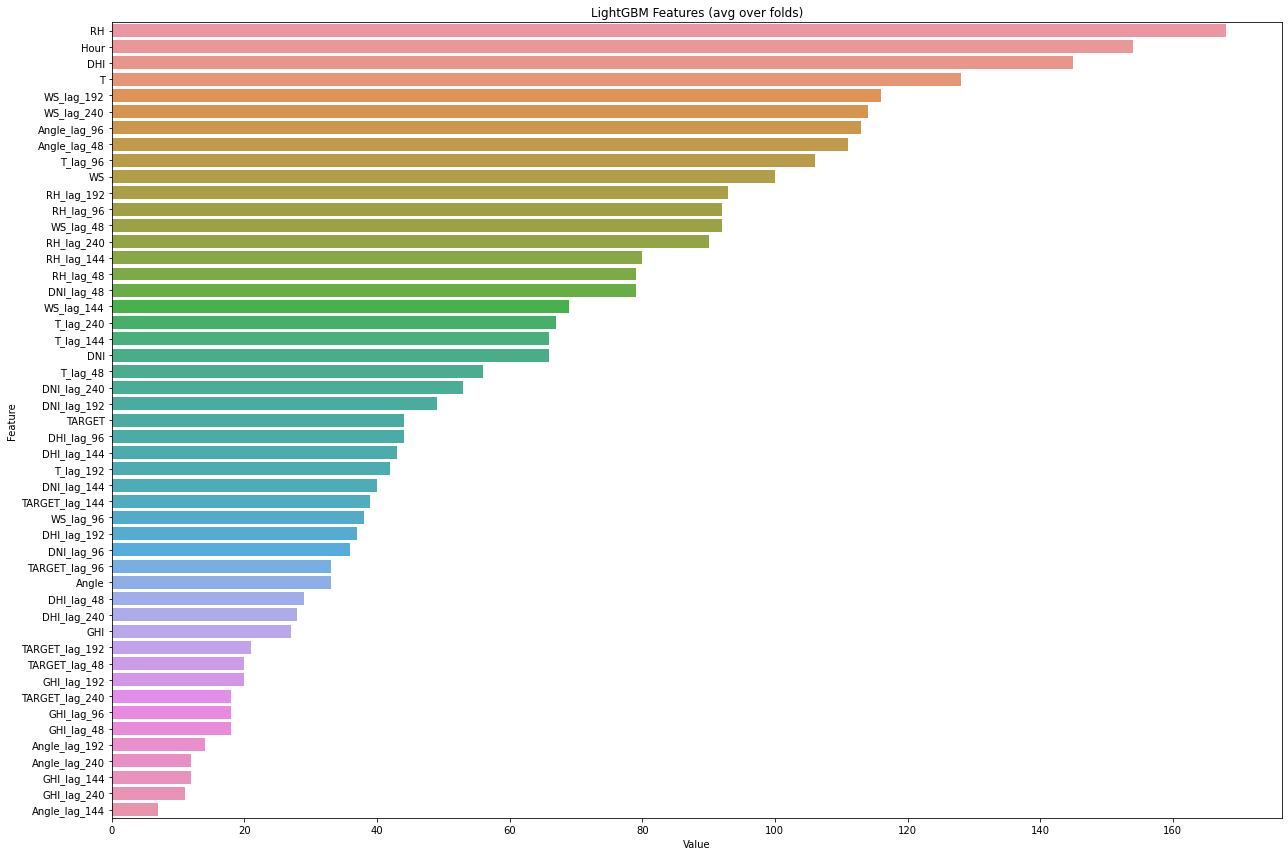

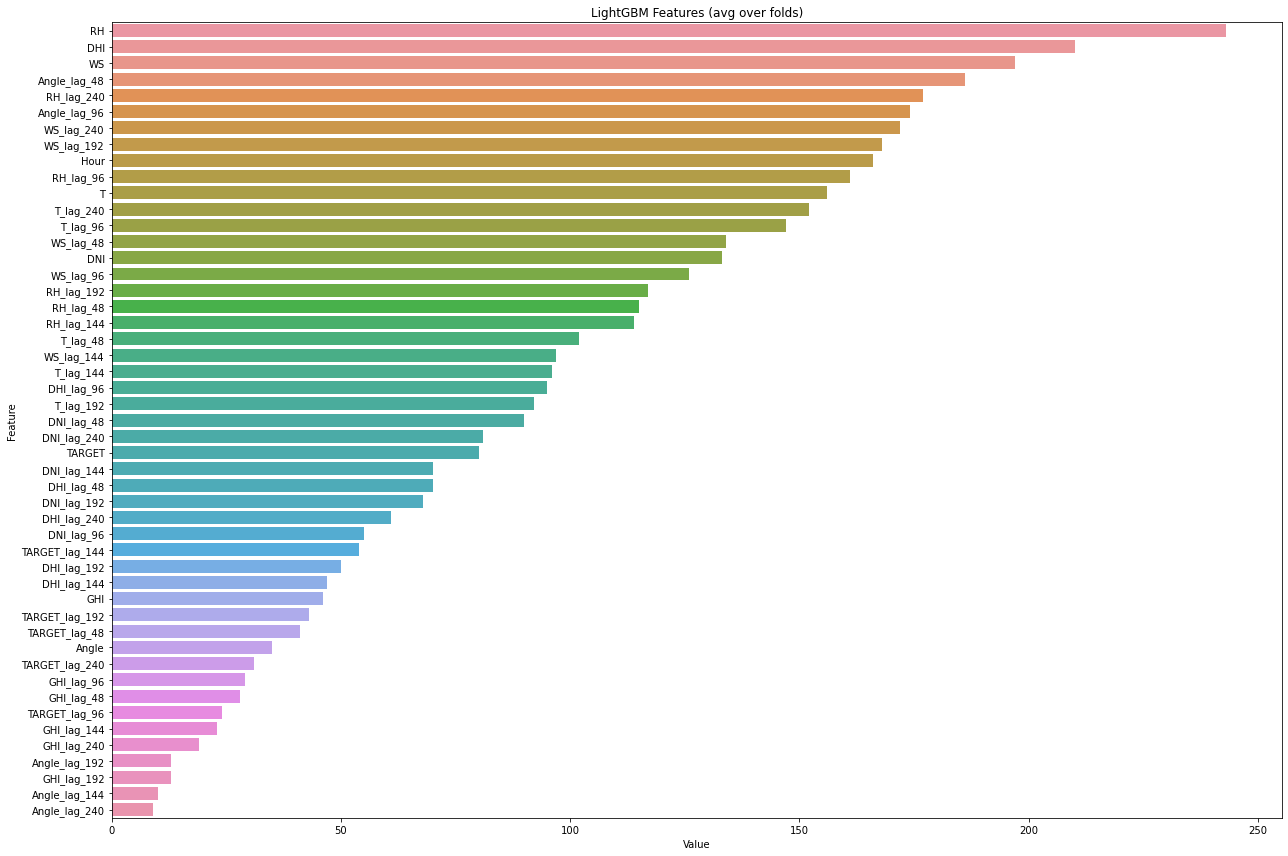

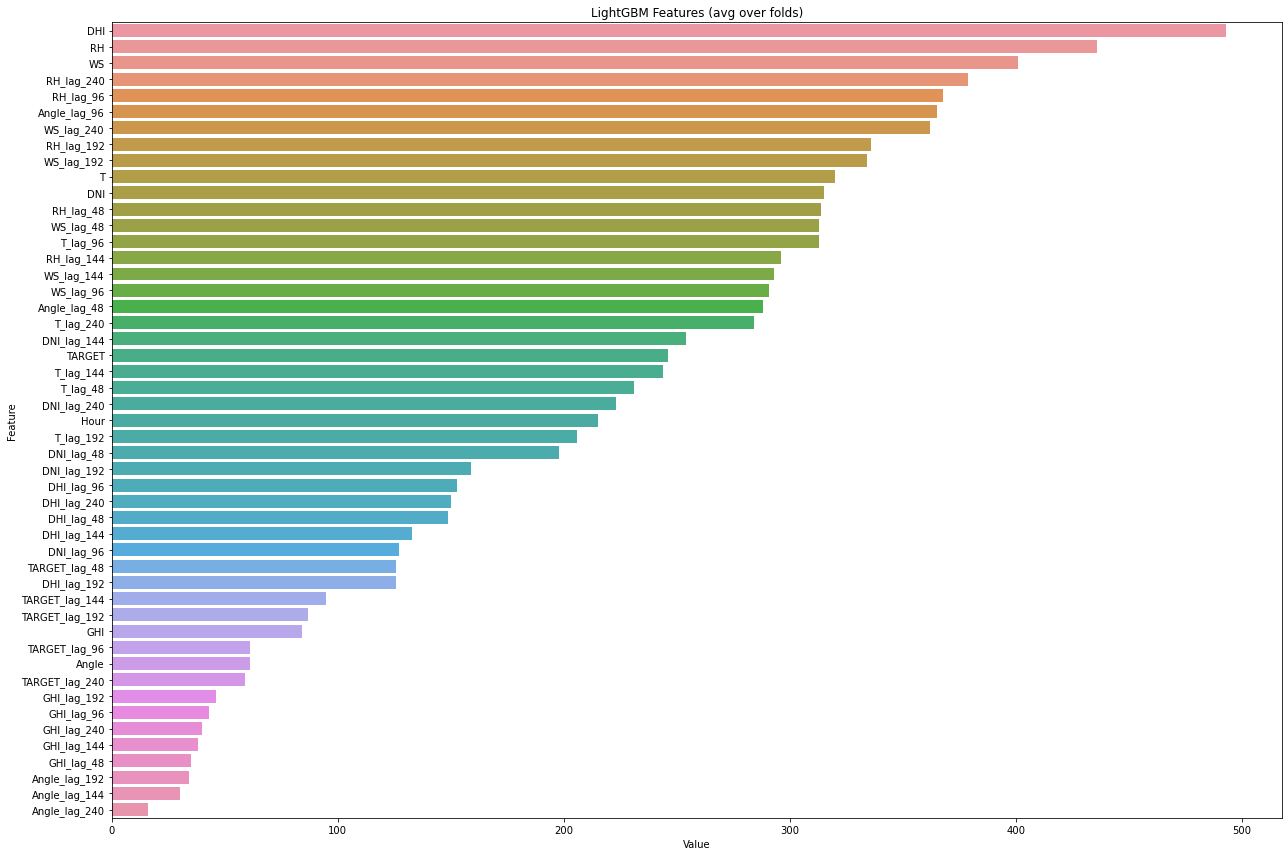

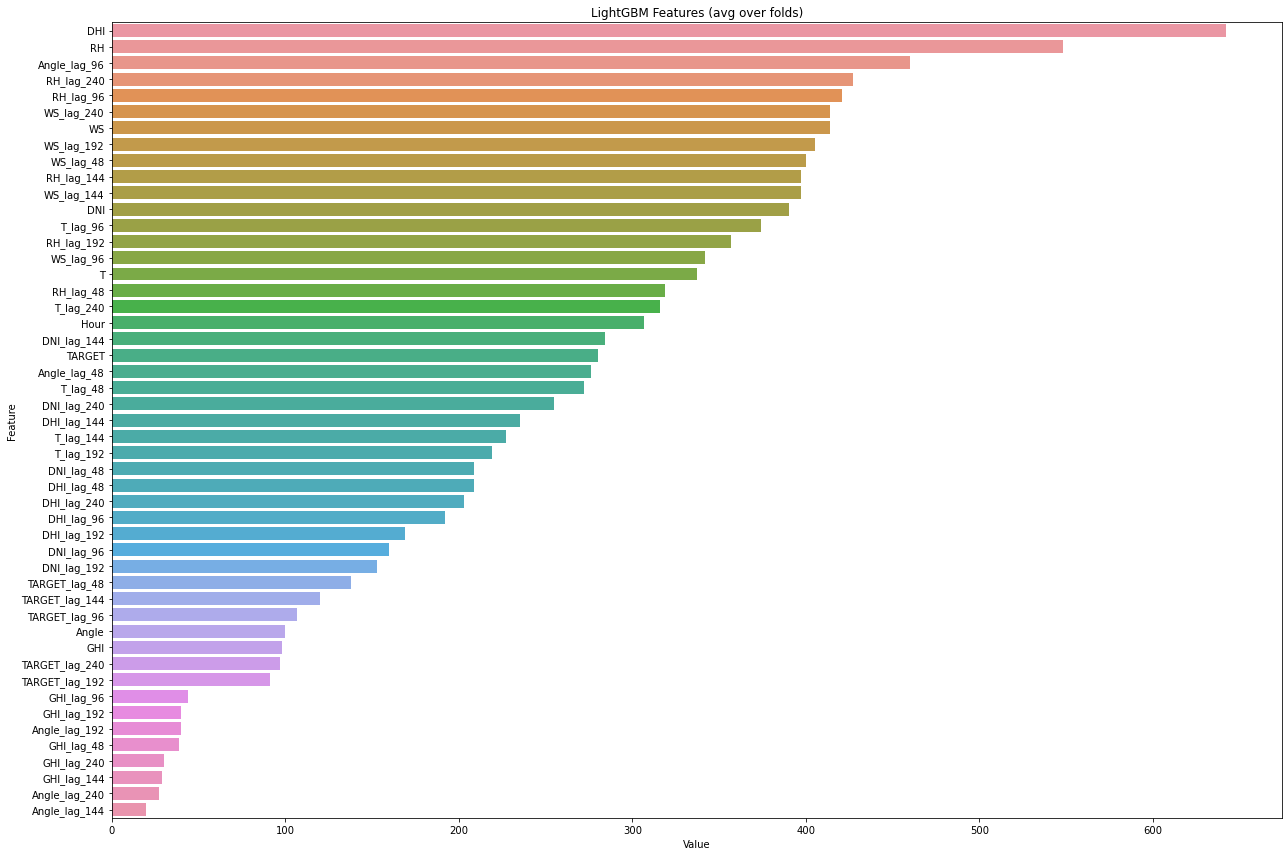

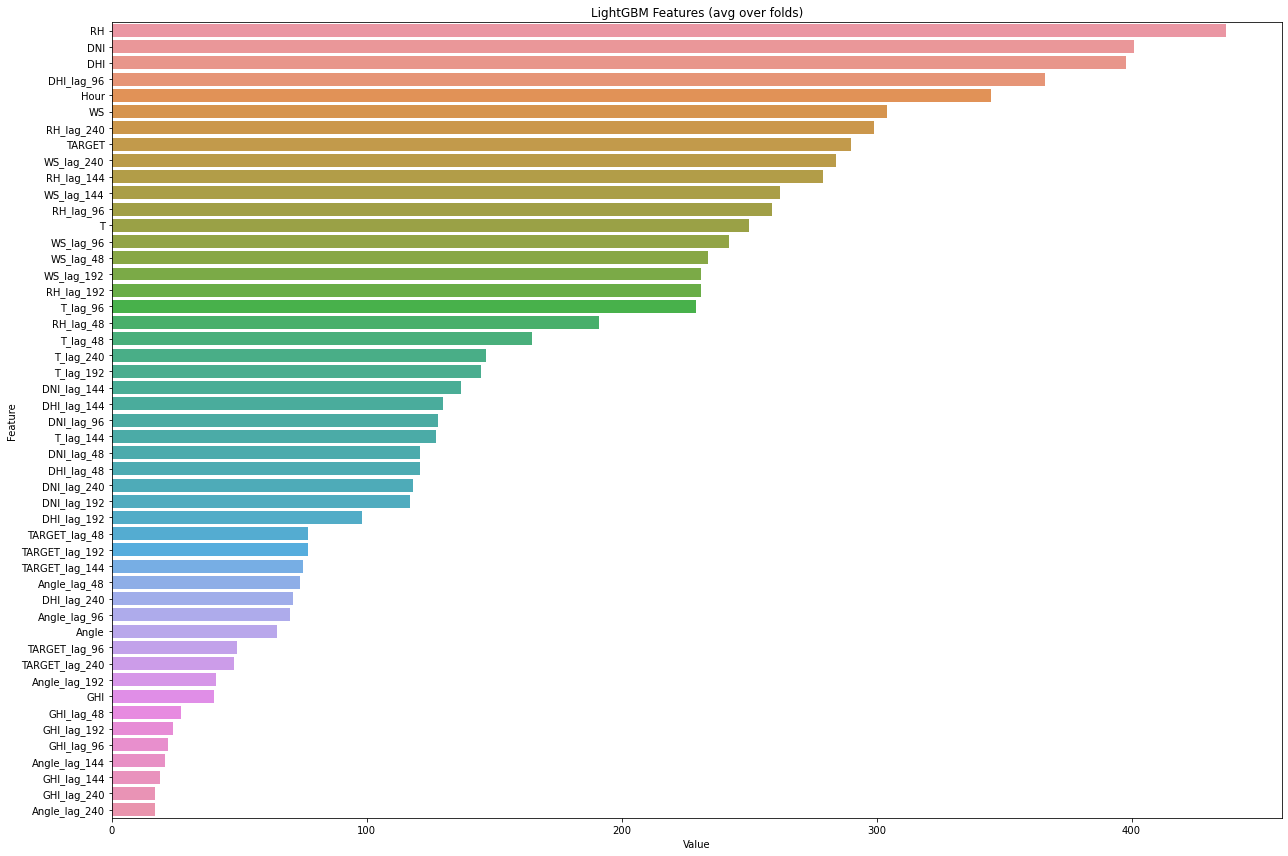

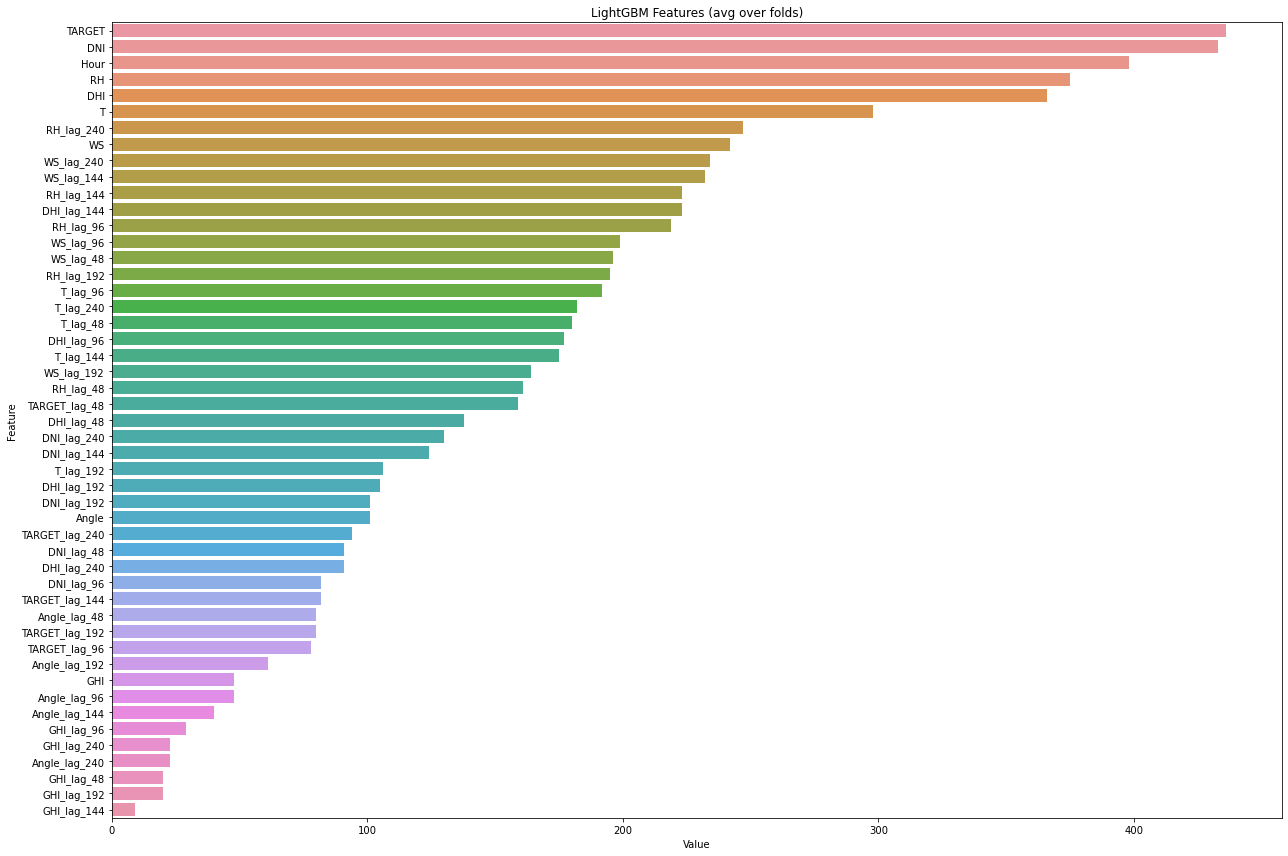

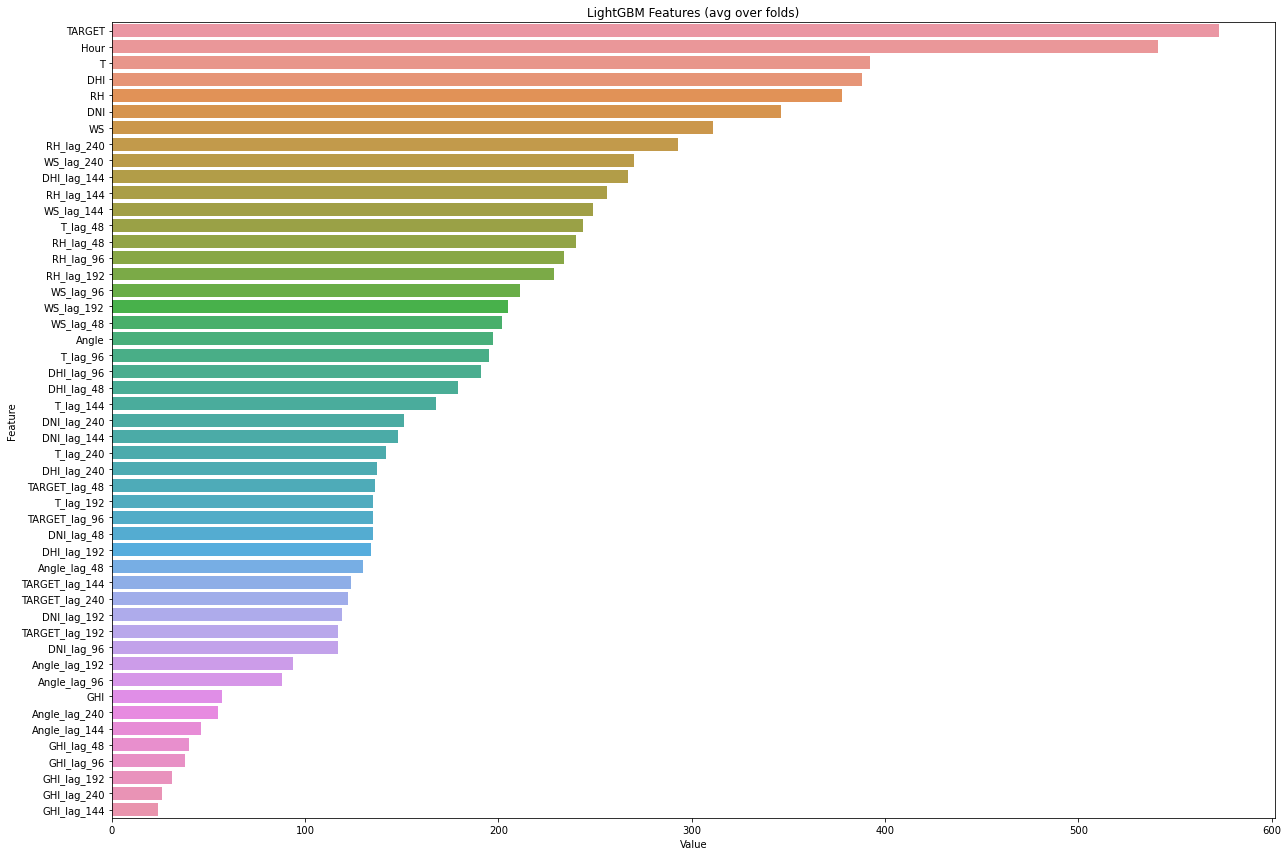

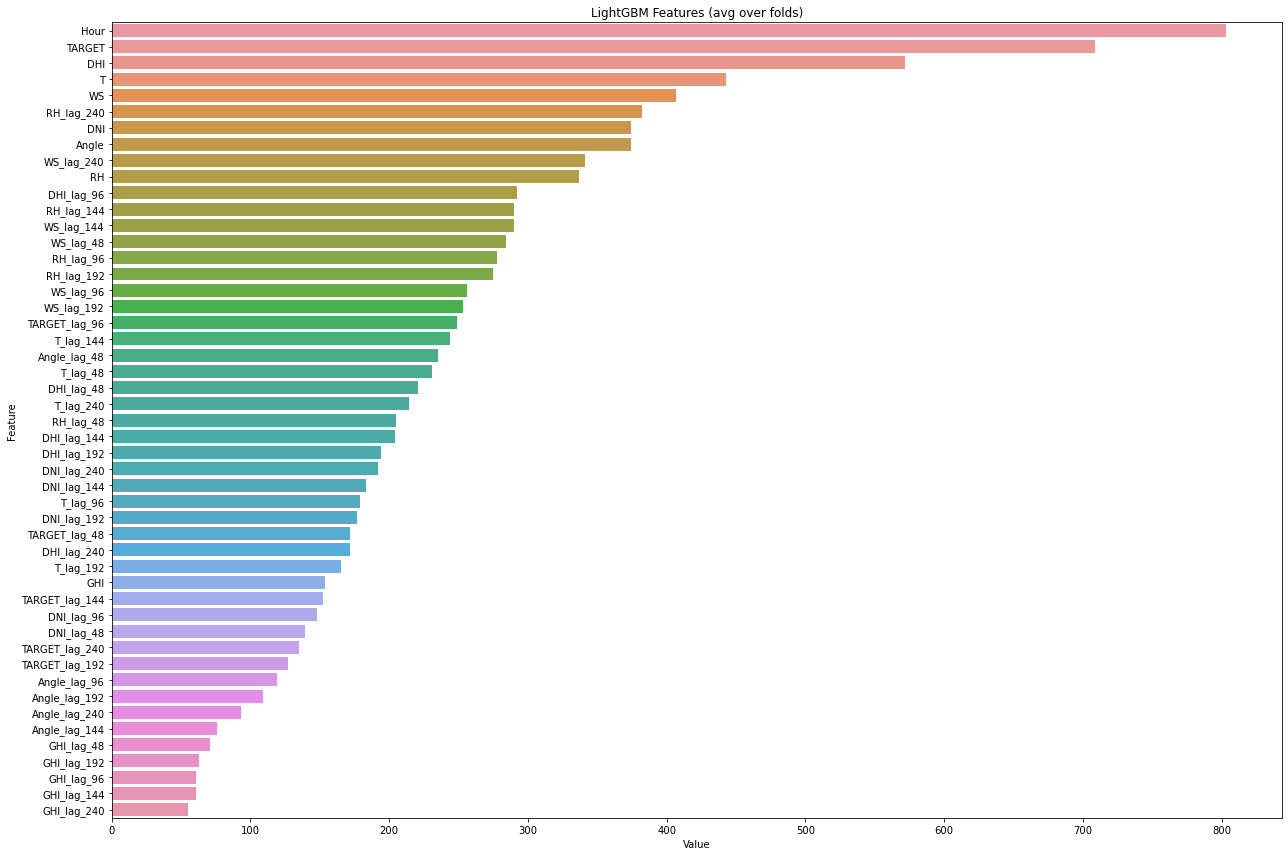

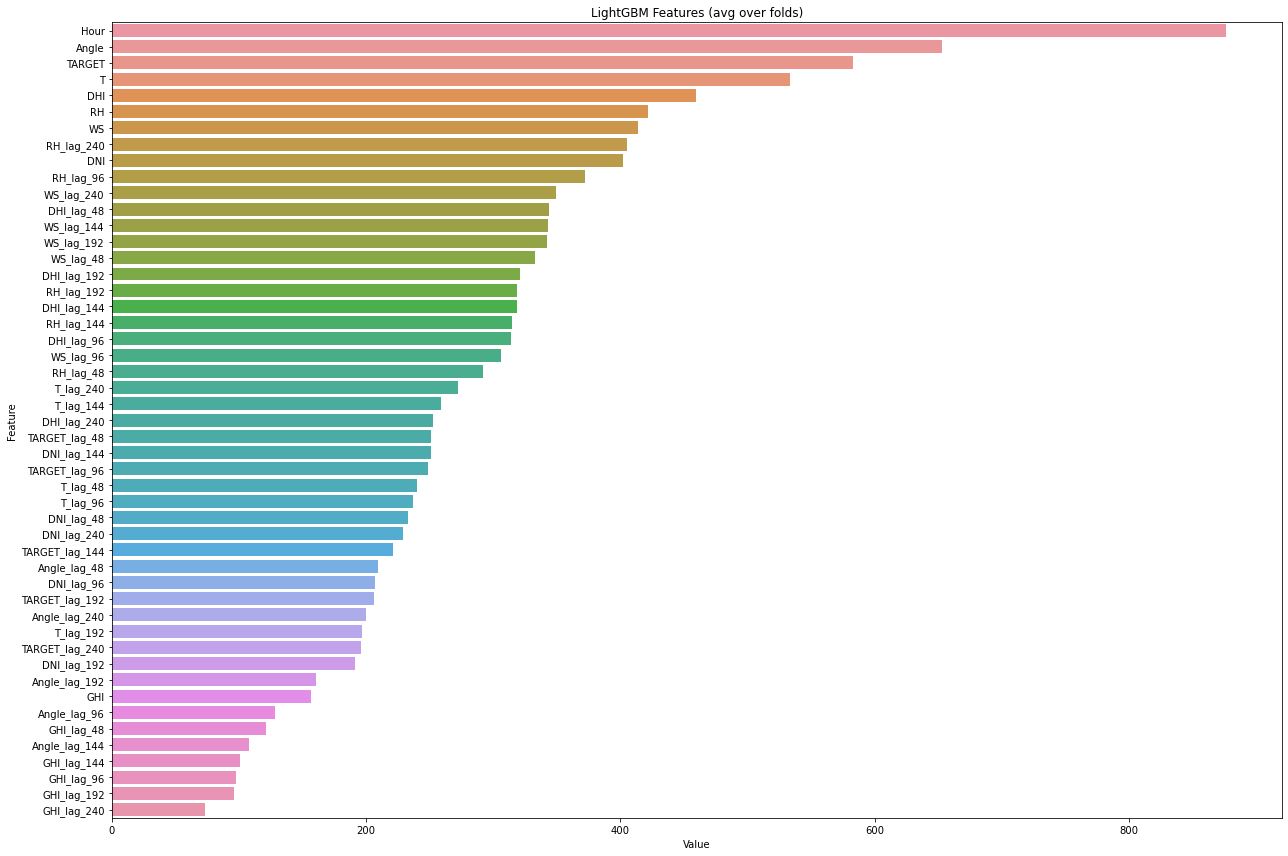

In [323]:
for i in range(len(models_1)):
    # sorted(zip(clf.feature_importances_, X.columns), reverse=True)
    feature_imp = pd.DataFrame(sorted(zip(models_1[i].feature_importances_,x_train.columns)),
                               columns=['Value','Feature'])

    plt.figure(figsize=(18, 12))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [324]:
# lag model 3 window decross model

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission[16:33]

#submission.to_csv('./submission/submission_210113-2_ghi3-shift.csv', index=False)

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
16,0.csv_Day7_8h00m,2.45,3.70,3.96,5.69,5.69,8.79,9.80,10.98,12.26
17,0.csv_Day7_8h30m,3.87,6.16,6.06,7.08,9.86,11.32,13.57,16.04,15.76
18,0.csv_Day7_9h00m,4.22,8.21,9.21,13.08,16.50,17.98,23.59,27.01,27.51
19,0.csv_Day7_9h30m,6.24,11.28,13.40,17.50,21.00,23.47,30.46,32.96,33.33
20,0.csv_Day7_10h00m,10.37,15.05,17.70,23.17,28.36,29.92,34.59,35.09,39.71
21,0.csv_Day7_10h30m,11.93,20.49,22.86,30.93,35.34,35.53,37.87,38.06,45.06
22,0.csv_Day7_11h00m,11.98,20.72,27.08,32.51,41.02,41.60,42.65,48.87,49.19
23,0.csv_Day7_11h30m,15.48,22.30,29.52,32.96,42.56,44.21,45.77,48.88,49.71
24,0.csv_Day7_12h00m,15.42,23.70,29.73,31.84,41.53,46.02,45.76,49.85,49.35
25,0.csv_Day7_12h30m,16.49,24.22,30.04,33.27,41.56,44.32,45.90,48.85,54.51
